### CNN Model Training

#### Imports

In [2]:
import tensorflow as tf
import pandas as pd
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

#### Load and Split Dataset
80% training, 20% validation

In [3]:
# Load and preprocess images
def load_image(image_name, label):
    image_path = tf.strings.join([image_folder, '/', image_name])
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [224, 224])  # Resize to match the input shape of the CNN
    image = image / 255.0  # Normalize pixel values to [0, 1]
    return image, label

# Create a TensorFlow dataset from a DataFrame
def create_tf_dataset(dataframe, image_folder, batch_size=32):
    image_names = dataframe['image'].values
    labels = dataframe['MEL'].values
    dataset = tf.data.Dataset.from_tensor_slices((image_names, labels))
    dataset = dataset.map(load_image, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.shuffle(buffer_size=1000).batch(batch_size).prefetch(buffer_size=tf.data.AUTOTUNE)
    return dataset

csv_path = '../preprocessed_dataset/ISIC_2019_Training_Balanced.csv'
image_folder = '../preprocessed_dataset'

# Load the CSV file
df = pd.read_csv(csv_path)
df['image'] = df['image'] + '.jpg'

# Split dataset into training and validation sets
train_df, val_df = train_test_split(df, test_size=0.2, random_state=42)

print(f"Training set size: {len(train_df)}")
print(f"Validation set size: {len(val_df)}")

# Create TensorFlow datasets for training and validation
train_dataset = create_tf_dataset(train_df, image_folder)
val_dataset = create_tf_dataset(val_df, image_folder)

print("Dataset loaded and preprocessed.")

Training set size: 31117
Validation set size: 7780
Dataset loaded and preprocessed.


#### Preview Dataset

Previewing training dataset:


2025-04-17 23:35:11.563285: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [31117]
	 [[{{node Placeholder/_0}}]]
2025-04-17 23:35:11.563862: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [31117]
	 [[{{node Placeholder/_1}}]]
2025-04-17 23:35:11.589423: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


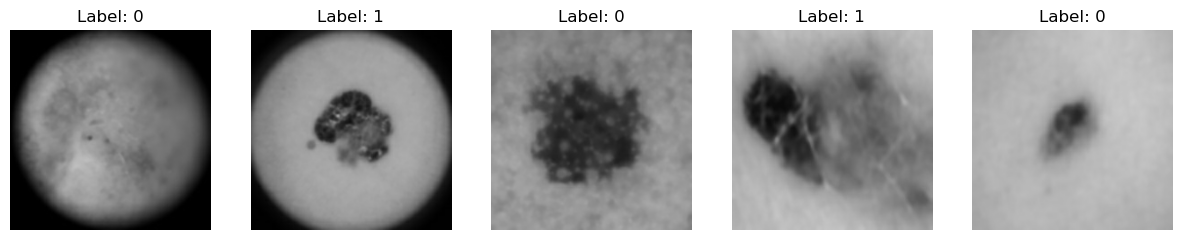

Previewing validation dataset:


2025-04-17 23:35:11.832868: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [7780]
	 [[{{node Placeholder/_1}}]]
2025-04-17 23:35:11.833049: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [7780]
	 [[{{node Placeholder/_0}}]]


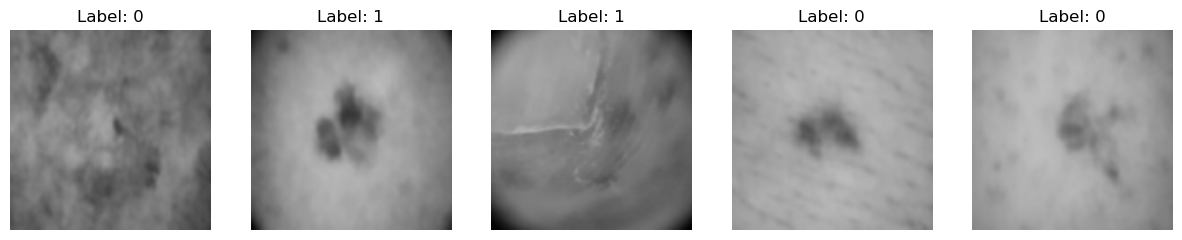

In [4]:
# Preview a batch of images and labels
def preview_dataset(dataset, num_images=5):
    for images, labels in dataset.take(1):  # Take one batch
        plt.figure(figsize=(15, 15))
        for i in range(num_images):
            ax = plt.subplot(1, num_images, i + 1)
            plt.imshow(images[i].numpy())
            plt.title(f"Label: {int(labels[i].numpy())}")
            plt.axis("off")
        plt.show()

# Preview the training dataset
print("Previewing training dataset:")
preview_dataset(train_dataset)

# Preview the validation dataset
print("Previewing validation dataset:")
preview_dataset(val_dataset)

#### Build the CNN Model

In [5]:
# build the cnn model from scratch 
def build_cnn_model():
    model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(1, activation='sigmoid')  # Output layer for binary classification
    ])
    
    # compile the model
    model.compile(optimizer='adam',
                loss='binary_crossentropy',  # Binary Cross Entropy for binary classification
                metrics=['accuracy'])
    
    return model

# actually build the model
model = build_cnn_model()
# show model architecture
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 111, 111, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 54, 54, 64)       0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 186624)            0         
                                                                 
 dense (Dense)               (None, 128)               2

#### Train the Model

In [6]:
# Define EarlyStopping callback
early_stopping = EarlyStopping(
    monitor='val_loss',  # monitor validation loss
    patience=10,         # wait for 10 epochs for improvement
    restore_best_weights=True,  # restore the best weights when training stops
    verbose=1
)

# Define ModelCheckpoint callback to save the best model
checkpoint = ModelCheckpoint(
    'best_model.h5',  # file where the model will be saved
    monitor='val_loss',  # monitor validation loss
    save_best_only=True,  # save the model only if the validation loss improves
    verbose=1
)

epochs = 50  
batch_size = 32

# Train the model with early stopping and model checkpoint
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=epochs,
    batch_size=batch_size,
    callbacks=[early_stopping, checkpoint]
)

Epoch 1/50


2025-04-17 23:35:41.811392: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [31117]
	 [[{{node Placeholder/_0}}]]
2025-04-17 23:35:41.811582: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [31117]
	 [[{{node Placeholder/_1}}]]


973/973 [==============================] - ETA: 0s - loss: 0.5551 - accuracy: 0.7162

2025-04-17 23:39:16.744166: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [7780]
	 [[{{node Placeholder/_1}}]]
2025-04-17 23:39:16.744340: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [7780]
	 [[{{node Placeholder/_1}}]]



Epoch 1: val_loss improved from inf to 0.53931, saving model to best_model.h5
973/973 [==============================] - 230s 236ms/step - loss: 0.5551 - accuracy: 0.7162 - val_loss: 0.5393 - val_accuracy: 0.7152
Epoch 2/50
973/973 [==============================] - ETA: 0s - loss: 0.4973 - accuracy: 0.7501
Epoch 2: val_loss improved from 0.53931 to 0.47800, saving model to best_model.h5
973/973 [==============================] - 227s 233ms/step - loss: 0.4973 - accuracy: 0.7501 - val_loss: 0.4780 - val_accuracy: 0.7627
Epoch 3/50
973/973 [==============================] - ETA: 0s - loss: 0.4839 - accuracy: 0.7609
Epoch 3: val_loss did not improve from 0.47800
973/973 [==============================] - 227s 233ms/step - loss: 0.4839 - accuracy: 0.7609 - val_loss: 0.4813 - val_accuracy: 0.7578
Epoch 4/50
973/973 [==============================] - ETA: 0s - loss: 0.4591 - accuracy: 0.7762
Epoch 4: val_loss improved from 0.47800 to 0.46254, saving model to best_model.h5
973/973 [========

#### Evaluate the Model
Binary Cross Entropy Loss

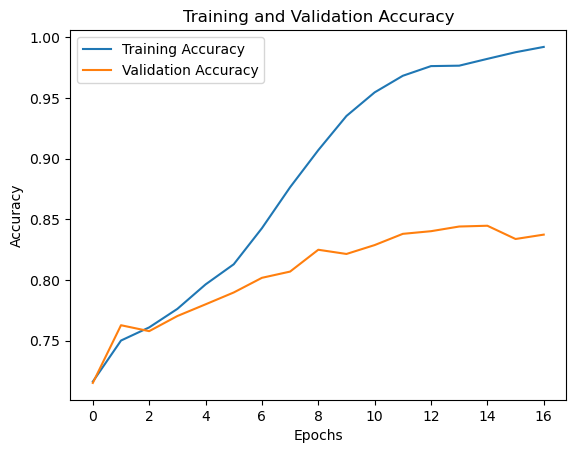

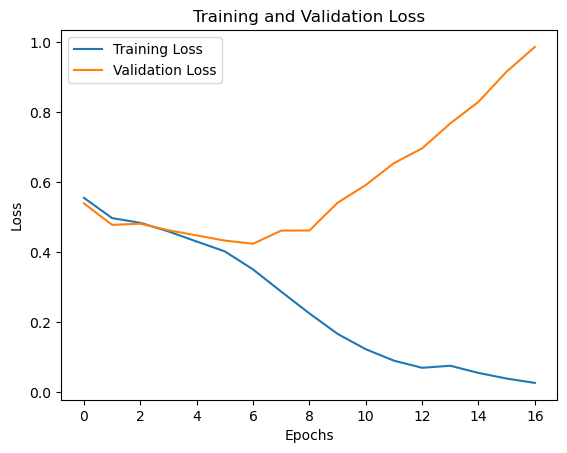

In [7]:
# Plot training and validation accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()